PROJECT TITLE : Intrusion Detection System

TEAM MEMBERS:
  1. Hemamalini S (TL) - SVM(LDA)
  2. Indhumathi K - NAIVE BAYES(LDA)
  3. Aswathi R - NAIVE BAYES(PCA)
  4. Jeevanantham S - LOGISTIC REGRESSION(LDA)
  5. Sebastin J - LOGISTIC REGRESSION(PCA)
  6. Dinesh R - SVM(PCA)

TEAM 5


ENV Setup

In [1]:
# import relevant modules
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import imblearn
#from cvxopt import matrix, solvers

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Settings
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.inf)  # Set threshold to a large value
np.set_printoptions(precision=3)
sns.set(style="darkgrid")
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

print("pandas : {0}".format(pd.__version__))
print("numpy : {0}".format(np.__version__))
print("matplotlib : {0}".format(matplotlib.__version__))
print("seaborn : {0}".format(sns.__version__))
print("sklearn : {0}".format(sklearn.__version__))
print("imblearn : {0}".format(imblearn.__version__))


pandas : 2.0.3
numpy : 1.25.2
matplotlib : 3.8.0
seaborn : 0.12.2
sklearn : 1.3.0
imblearn : 0.11.0


Load DATA

In [2]:
# Dataset field names
datacols = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

# Load NSL_KDD train dataset
dfkdd_train = pd.read_table("SampleKDDTrain.txt", sep=",", names=datacols) # change path to where the dataset is located.
dfkdd_train = dfkdd_train.iloc[:,:-1] # removes an unwanted extra field

# Load NSL_KDD test dataset
dfkdd_test = pd.read_table("SampleKDDTest.txt", sep=",", names=datacols)
dfkdd_test = dfkdd_test.iloc[:,:-1]

DATA Preprocessing

In [3]:
mapping = {'ipsweep': 'Probe','satan': 'Probe','nmap': 'Probe','portsweep': 'Probe','saint': 'Probe','mscan': 'Probe',
        'teardrop': 'DoS','pod': 'DoS','land': 'DoS','back': 'DoS','neptune': 'DoS','smurf': 'DoS','mailbomb': 'DoS',
        'udpstorm': 'DoS','apache2': 'DoS','processtable': 'DoS',
        'perl': 'U2R','loadmodule': 'U2R','rootkit': 'U2R','buffer_overflow': 'U2R','xterm': 'U2R','ps': 'U2R',
        'sqlattack': 'U2R','httptunnel': 'U2R',
        'ftp_write': 'R2L','phf': 'R2L','guess_passwd': 'R2L','warezmaster': 'R2L','warezclient': 'R2L','imap': 'R2L',
        'spy': 'R2L','multihop': 'R2L','named': 'R2L','snmpguess': 'R2L','worm': 'R2L','snmpgetattack': 'R2L',
        'xsnoop': 'R2L','xlock': 'R2L','sendmail': 'R2L',
        'normal': 'Normal'
        }

In [4]:
# Apply attack class mappings to the dataset
dfkdd_train['attack_class'] = dfkdd_train['attack'].apply(lambda v: mapping[v])
dfkdd_test['attack_class'] = dfkdd_test['attack'].apply(lambda v: mapping[v])

In [5]:
# Drop attack field from both train and test data
dfkdd_train.drop(['attack'], axis=1, inplace=True)
dfkdd_test.drop(['attack'], axis=1, inplace=True)

In [6]:
# View top 3 train data 
dfkdd_train.head(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.0,150,25,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,Normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.0,255,1,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,Normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.0,255,26,0.10,0.05,0.00,0.0,1.0,1.0,0.00,0.0,DoS


Exploratory Data Analysis

In [7]:
# Descriptive statistics
dfkdd_train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,1637.000000,1.637000e+03,1637.000000,1637.0,1637.000000,1637.0,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.0,1637.000000,1637.0,1637.0,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000,1637.000000
mean,217.045205,5.522674e+03,1748.136225,0.0,0.028100,0.0,0.163103,0.001833,0.390959,0.262065,0.000611,0.001833,0.282834,0.005498,0.0,0.004887,0.0,0.0,0.006720,83.645693,24.627367,0.293549,0.291356,0.128662,0.130800,0.648186,0.063519,0.092224,184.081246,113.203421,0.508998,0.080910,0.138925,0.034948,0.294869,0.289194,0.123189,0.128681
std,2067.567923,1.385185e+05,11507.377567,0.0,0.286949,0.0,1.873351,0.055253,0.488114,9.285231,0.024716,0.055253,10.511492,0.199251,0.0,0.069757,0.0,0.0,0.081722,109.693557,63.814191,0.451842,0.452104,0.331931,0.335835,0.443230,0.179803,0.253021,98.251462,111.029147,0.451484,0.183581,0.300114,0.123166,0.451153,0.451612,0.309877,0.329653
min,0.000000,0.000000e+00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.080000,0.000000,0.000000,89.000000,10.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.200000e+01,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,57.000000,0.410000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.640000e+02,493.000000,0.0,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,145.000000,17.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.050000,0.020000,1.000000,1.000000,0.000000,0.000000
max,41285.000000,5.131424e+06,398456.000000,0.0,3.000000,0.0,30.000000,2.000000,1.000000,375.000000,1.000000,2.000000,425.000000,8.000000,0.0,1.000000,0.0,0.0,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


ENCODER

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Define columns to be one-hot encoded
categorical_columns = ['protocol_type', 'service', 'flag']

# Create separate dataframes for the training and test data
X_train = dfkdd_train.drop(['attack_class'], axis=1)  # Features in the training dataset
X_test = dfkdd_test.drop(['attack_class'], axis=1)    # Features in the test dataset
y_train = dfkdd_train['attack_class']                # Target variable in the training dataset
y_test = dfkdd_test['attack_class']                  # Target variable in the test dataset

# Perform one-hot encoding on categorical columns
encoder = OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore')
X_train_encoded = encoder.fit_transform(X_train[categorical_columns])
X_test_encoded = encoder.transform(X_test[categorical_columns])

# Combine the encoded features with the original numeric features
X_train = np.hstack((X_train.drop(categorical_columns, axis=1), X_train_encoded))
X_test = np.hstack((X_test.drop(categorical_columns, axis=1), X_test_encoded))

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


PCA

In [9]:
from sklearn.decomposition import PCA
# Number of components to retain
n_components = 10  # You can adjust this number as needed

# Create PCA instances and fit to the training data
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
# Create new DataFrames for the PCA-transformed data
dfkdd_train_pca = pd.DataFrame(data=X_train_pca, columns=[f'PC{i}' for i in range(1, n_components + 1)])
dfkdd_test_pca = pd.DataFrame(data=X_test_pca, columns=[f'PC{i}' for i in range(1, n_components + 1)])
# Add the 'attack_class' column back to the PCA-transformed DataFrames
dfkdd_train_pca['attack_class'] = y_train
dfkdd_test_pca['attack_class'] = y_test


In [10]:
dfkdd_train_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,attack_class
0,-1.039572,-0.062380,-0.027385,-0.191720,-0.597644,0.551490,0.001606,0.828645,0.097296,-1.443903,Normal
1,-0.418353,1.863063,-0.821443,4.171270,-0.747984,1.375647,0.471124,3.989162,-0.418834,-1.532926,Normal
2,4.298191,-1.358360,0.011281,-0.055796,-0.325303,0.014266,-0.018263,0.400409,-0.353828,0.575331,DoS
3,-2.813653,-1.174906,0.253315,-1.693567,0.079140,-0.544778,0.031521,0.170211,0.296836,0.231423,Normal
4,-2.622014,-1.007987,0.006091,-1.237004,0.882330,-0.799813,-0.157316,0.276126,0.348483,0.101458,Normal


In [11]:
dfkdd_test_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,attack_class
0,1.956282,5.315939,-0.038249,-0.716767,1.052988,-0.975762,-0.289764,-1.248148,-0.570647,0.235224,DoS
1,1.848205,5.334167,0.009026,-0.882386,0.888808,-0.862166,-0.271547,-1.032604,-0.800460,0.293512,DoS
2,-1.616993,-0.108932,-0.124944,0.052367,-1.108237,0.675875,-0.005675,0.749797,0.547854,-1.380206,Normal
3,-3.301118,0.017189,-0.786311,2.658394,-5.423875,2.319146,-0.247268,-2.904548,-0.360459,0.793553,Probe
4,-0.258054,4.601145,1.346194,-1.422670,-0.135196,-0.143828,1.492773,-3.750019,-2.222936,-1.242261,Probe


LDA

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Create an LDA instance
lda = LinearDiscriminantAnalysis()

# Fit LDA on the training data
X_train_lda = lda.fit_transform(X_train, y_train)

# Transform the test data using the trained LDA model
X_test_lda = lda.transform(X_test)


In [13]:
print(X_train_lda)

[[ 3.323e+00 -1.699e+00  1.816e-01]
 [ 7.182e-01  8.798e-01 -5.387e-01]
 [-5.387e+00 -1.416e-01  9.228e-02]
 [ 2.810e+00 -1.112e+00 -7.109e-01]
 [ 3.083e+00 -1.112e+00 -2.111e-01]
 [-3.661e+00  5.059e-01 -1.346e-01]
 [-5.422e+00 -5.962e-02  4.186e-02]
 [-5.166e+00 -6.208e-02 -4.481e-02]
 [-4.732e+00  4.723e-01 -4.904e-01]
 [-5.427e+00 -1.044e-01  5.801e-03]
 [-3.840e+00  7.013e-01 -3.223e-02]
 [-5.367e+00  1.216e-01  6.391e-02]
 [ 3.357e+00 -9.466e-01 -2.531e-01]
 [ 3.079e+00  2.844e-01  6.391e+00]
 [-5.650e+00 -4.189e-01 -1.366e-02]
 [-5.698e+00 -7.501e-01 -9.391e-02]
 [ 2.977e+00 -1.011e+00 -6.656e-01]
 [ 2.571e+00  7.801e+00  2.112e+00]
 [ 3.462e+00 -1.368e+00 -4.858e-01]
 [ 3.344e+00 -1.037e+00 -3.767e-01]
 [-5.426e+00 -5.513e-01  5.676e-02]
 [-5.083e+00  3.113e-01  8.595e-02]
 [ 3.382e+00 -1.190e+00 -5.641e-01]
 [ 4.154e+00  2.150e+00 -8.835e-01]
 [-5.657e+00 -4.853e-01  2.246e-02]
 [ 1.432e+00 -1.770e+00 -3.351e-01]
 [-5.133e+00  3.675e-01  1.092e-01]
 [ 2.333e+00 -9.098e-02 -7.4

In [14]:
print(X_test_lda)

[[-3.869e+00  7.132e-01 -1.239e-02]
 [-4.238e+00  3.999e-01 -1.200e-01]
 [ 3.928e+00 -8.695e-01  2.186e+00]
 [ 1.581e+00  5.923e+00  2.416e-01]
 [-1.714e+00 -1.383e+00 -1.201e+00]
 [ 3.321e+00 -1.246e+00 -3.213e-01]
 [ 2.648e+00  1.176e+00 -2.350e+00]
 [ 8.356e+00 -1.513e-01  1.895e+01]
 [ 3.181e+00 -1.148e+00 -3.535e-01]
 [ 1.321e+01 -6.061e-01  2.490e+01]
 [ 2.208e+00 -1.138e+00 -1.083e+00]
 [ 2.678e+00 -1.337e+00 -9.327e-01]
 [-4.211e+00  4.015e-01 -1.197e-01]
 [-1.705e+00  1.480e-01  1.227e-01]
 [ 2.200e+00 -1.044e+00 -1.540e+00]
 [ 3.462e+00 -1.293e+00 -4.803e-01]
 [ 3.114e+00 -1.197e+00 -1.742e-01]
 [ 3.509e+00 -1.258e+00 -4.997e-01]
 [ 2.650e+00  2.698e+00  1.617e+00]
 [-3.681e+00  7.412e-01 -2.659e-02]
 [-3.924e+00 -1.169e-01 -8.875e-02]
 [-8.544e-01 -1.988e+00 -4.806e-01]
 [ 3.134e+00 -1.215e+00 -1.747e-01]
 [ 3.464e+00 -1.277e+00 -5.856e-01]
 [-4.153e+00  8.485e-02 -4.084e-02]
 [-4.712e+00 -1.952e-01  3.652e-02]
 [ 3.078e+00 -1.165e+00 -3.622e-01]
 [ 3.171e+00 -1.242e+00 -1.7

SVM(LDA)

In [15]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Create an SVM classifier with the appropriate settings
svm_classifier = SVC()

# Fit the SVM classifier on the LDA-transformed training data
svm_classifier.fit(X_train_lda, y_train)

# Predict the classes on the LDA-transformed test data
y_pred = svm_classifier.predict(X_test_lda)

# Evaluate the SVM classifier
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Accuracy: 0.7669172932330827
Classification Report:
               precision    recall  f1-score   support

         DoS       0.96      0.79      0.87       135
      Normal       0.67      0.99      0.80       175
       Probe       0.92      0.51      0.66        43
         R2L       1.00      0.10      0.18        41
         U2R       0.00      0.00      0.00         5

    accuracy                           0.77       399
   macro avg       0.71      0.48      0.50       399
weighted avg       0.82      0.77      0.73       399



SVM (PCA)

In [16]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Separate the features and target variable for PCA-transformed data
X_train_pca = dfkdd_train_pca.drop(['attack_class'], axis=1)
y_train_pca = dfkdd_train_pca['attack_class']
X_test_pca = dfkdd_test_pca.drop(['attack_class'], axis=1)
y_test_pca = dfkdd_test_pca['attack_class']

# Create an SVM classifier
svm_classifier = SVC(kernel='linear', C=1.0)

# Fit the SVM classifier to the training data
svm_classifier.fit(X_train_pca, y_train_pca)


# Make predictions on the test data
y_pred = svm_classifier.predict(X_test_pca)

# Evaluate the classifier
accuracy = accuracy_score(y_test_pca, y_pred)
report = classification_report(y_test_pca, y_pred)

# Print the accuracy and classification report
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:\n', report)


Accuracy: 0.78
Classification Report:
               precision    recall  f1-score   support

         DoS       0.84      0.83      0.84       135
      Normal       0.72      0.94      0.81       175
       Probe       0.93      0.58      0.71        43
         R2L       0.91      0.24      0.38        41
         U2R       0.00      0.00      0.00         5

    accuracy                           0.78       399
   macro avg       0.68      0.52      0.55       399
weighted avg       0.79      0.78      0.76       399



NB(LDA)

In [17]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create a Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

# Fit the classifier on the LDA-transformed training data
nb_classifier.fit(X_train_lda, y_train)

# Make predictions on the LDA-transformed test data
y_pred = nb_classifier.predict(X_test_lda)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')


Accuracy: 0.8145363408521303
Confusion Matrix:
[[110  14  11   0   0]
 [  0 160  12   3   0]
 [  5   8  30   0   0]
 [  0  16   0  25   0]
 [  0   4   1   0   0]]
Classification Report:
              precision    recall  f1-score   support

         DoS       0.96      0.81      0.88       135
      Normal       0.79      0.91      0.85       175
       Probe       0.56      0.70      0.62        43
         R2L       0.89      0.61      0.72        41
         U2R       0.00      0.00      0.00         5

    accuracy                           0.81       399
   macro avg       0.64      0.61      0.61       399
weighted avg       0.82      0.81      0.81       399



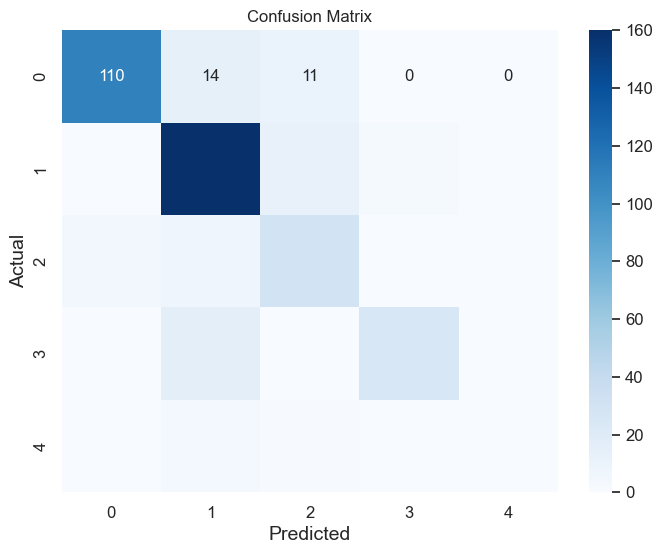

In [18]:
from sklearn.metrics import confusion_matrix
# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', )
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

NB(PCA)

In [19]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Separate features and target variable in PCA-transformed data
X_train_pca = dfkdd_train_pca.drop(['attack_class'], axis=1)
y_train = dfkdd_train_pca['attack_class']
X_test_pca = dfkdd_test_pca.drop(['attack_class'], axis=1)
y_test = dfkdd_test_pca['attack_class']

# Create a Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

# Fit the classifier to the training data
nb_classifier.fit(X_train_pca, y_train)

# Predict on the test data
y_pred = nb_classifier.predict(X_test_pca)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report_str)


Accuracy: 0.80

Classification Report:
              precision    recall  f1-score   support

         DoS       0.85      0.78      0.81       135
      Normal       0.80      0.97      0.88       175
       Probe       0.63      0.63      0.63        43
         R2L       0.90      0.46      0.61        41
         U2R       0.00      0.00      0.00         5

    accuracy                           0.80       399
   macro avg       0.64      0.57      0.59       399
weighted avg       0.80      0.80      0.79       399



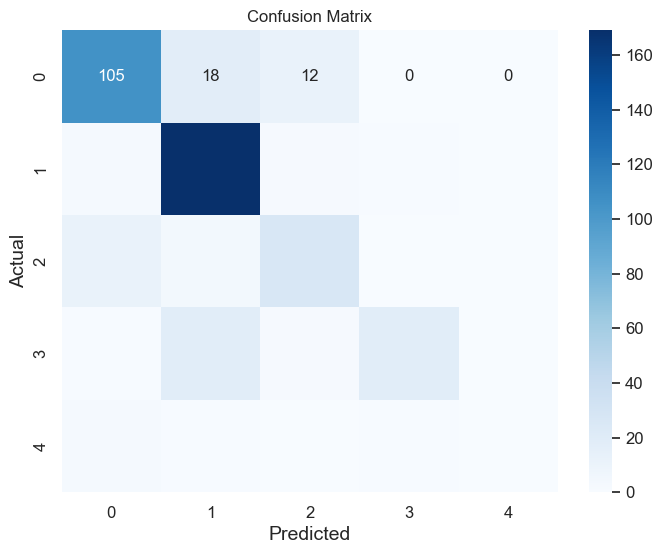

In [20]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', )
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

LOGISTIC REGRESSION(PCA)

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Separate features and target variable
X_train = dfkdd_train_pca.drop(['attack_class'], axis=1)
y_train = dfkdd_train_pca['attack_class']
X_test = dfkdd_test_pca.drop(['attack_class'], axis=1)
y_test = dfkdd_test_pca['attack_class']

# Create and fit a logistic regression model
logistic_reg_model = LogisticRegression(max_iter=10000, random_state=42)
logistic_reg_model.fit(X_train, y_train)

# Predict on the test data
y_pred = logistic_reg_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the results
print("Accuracy:", accuracy)
print("Classification Report:\n", report)


Accuracy: 0.7568922305764411
Classification Report:
               precision    recall  f1-score   support

         DoS       0.85      0.81      0.83       135
      Normal       0.69      0.94      0.80       175
       Probe       0.89      0.56      0.69        43
         R2L       0.80      0.10      0.17        41
         U2R       0.00      0.00      0.00         5

    accuracy                           0.76       399
   macro avg       0.65      0.48      0.50       399
weighted avg       0.77      0.76      0.72       399



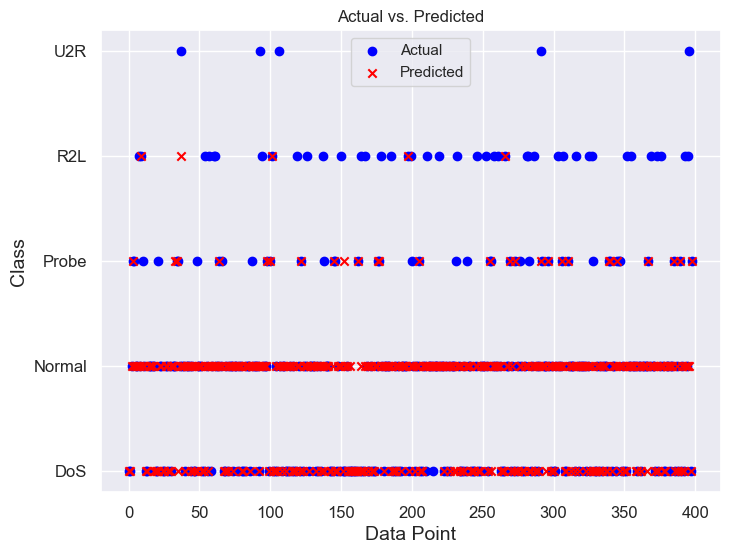

In [22]:
import matplotlib.pyplot as plt

# Assuming 'y_test' contains the true labels and 'y_pred' contains the predicted labels
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual')
plt.scatter(range(len(y_pred)), y_pred, color='red', marker='x', label='Predicted')
plt.title('Actual vs. Predicted')
plt.xlabel('Data Point')
plt.ylabel('Class')
plt.legend()
plt.show()


LOGISTIC REGRESSION(LDA)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create a Logistic Regression instance
logistic_regression = LogisticRegression(max_iter=1000, random_state=42)

# Fit the Logistic Regression model on the LDA-transformed training data
logistic_regression.fit(X_train_lda, y_train)

# Make predictions on the LDA-transformed test data
y_pred = logistic_regression.predict(X_test_lda)

# Calculate the accuracy of the model on the test data
accuracy = accuracy_score(y_test, y_pred)
Report = classification_report(y_test, y_pred)
print(f"Accuracy of Logistic Regression: {accuracy:.2f}")
print(f"Classification Report:\n",Report)


Accuracy of Logistic Regression: 0.80
Classification Report:
               precision    recall  f1-score   support

         DoS       0.94      0.84      0.89       135
      Normal       0.71      0.98      0.82       175
       Probe       0.92      0.51      0.66        43
         R2L       0.92      0.27      0.42        41
         U2R       0.00      0.00      0.00         5

    accuracy                           0.80       399
   macro avg       0.70      0.52      0.56       399
weighted avg       0.82      0.80      0.78       399

